<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/ML_HIDS_ADFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Processing data**

In [ ]:
#@title Specify parameters before running

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = False #@param {type:"boolean"} 
SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix

from sklearn.model_selection import train_test_split
%matplotlib inline

DATA = 'ADFA-LD'

import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
# Load data and unzip them
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true'
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Attack_Data_Master.zip?raw=true'


--2022-02-09 16:49:42--  https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2022-02-09 16:49:42--  https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2022-02-09 16:49:42--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [ ]:
# Rename files
! mv Attack_Data_Master.zip?raw=true   Attack_Data_Master.zip
! mv Training_Data_Master.zip?raw=true Training_Data_Master.zip

# Unzip files
! unzip Training_Data_Master.zip
! unzip Attack_Data_Master.zip

**Syscall sequences in ADFA-LD are organized by folder, so we assume that they are already grouped by PID**

In [ ]:
from glob import glob
import os
train_dir = 'Training_Data_Master/'
test_dir  = 'Attack_Data_Master/'

# Read data in a dataframe
def read_in_data(path, is_normal = 1): 
  lines = []
  if is_normal == 1:
    for filename in os.listdir(path): # iterate through all label folders in a directory 
      with open(path+filename) as f:
        lines.append(f.read())
       # data = pd.read_csv(path+filename, sep=' ', header=None)
       # list_of_dataframes.append(data.stack())
    
  else:
    for folder in os.listdir(path): # iterate through different attack folders in a directory
      files = glob(str(path + folder +"/*.txt"), recursive=False) # get a list of files from each label folder 
      for filename in files: 
        with open(filename) as f:
          lines.append(f.read())
        #data = pd.read_csv(filename, sep=' ', header=None)
        #lines.append(data.stack())

  df = pd.DataFrame(lines)
  #df = df.astype('int32')
  #df = pd.DataFrame(df)
  return df   

In [ ]:
# Trainning set
train = read_in_data(train_dir)
train.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Normal training data size:', train.shape)
train.head(5)

Normal training data size: (833, 1)


,Syscall Sequence
0,6 175 174 174 174 174 174 174 11 45 33 192 33 ...
1,174 174 174 174 174 174 221 221 221 221 221 22...
2,6 175 174 174 174 174 174 174 11 45 33 192 33 ...
3,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...
4,199 213 5 63 6 63 6 11 45 33 192 33 5 197 192 ...


In [ ]:
# Testing set
test = read_in_data(test_dir, is_normal = 0)
test.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Intrusion Testing data size:', test.shape)
test.head(5)

Intrusion Testing data size: (746, 1)


,Syscall Sequence
0,3 168 3 168 265 168 3 168 168 168 265 168 168 ...
1,265 168 3 265 43 168 3 168 43 265 3 168 3 3 16...
2,168 265 168 265 168 265 168 168 265 265 168 16...
3,78 78 104 174 168 102 168 168 102 102 91 183 1...
4,162 5 3 91 5 3 5 3 5 5 3 5 6 5 5 3 91 3 91 91 ...


## **Data Parsing**

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import ngrams


## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid.index:
    token = word_tokenize(seq_per_pid.iloc[p]['Syscall Sequence'])  # Tokenize the string of sequence

    # Parse the sequence into length of SEQ_WINDOW
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW, pad_right=True, right_pad_symbol=-1)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(train)
normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,6,175,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33
1,175,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5
2,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3
3,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3,197
4,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3,197,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,195,195,195,91,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
175,195,195,91,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
176,195,91,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
177,91,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
print('Parsing Intrusion')
intrusion = parse_seq(test)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,168,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168
1,168,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168
2,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265
3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265,168
4,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,168,168,168,265,168,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
933,168,168,265,168,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
934,168,265,168,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
935,265,168,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## **Preparing data for data partition**
- Combine data and labels together. 
- Combine data from each class together --> Create a pool of data 
- Split data pool into train and test

## **Cleaning**
- Remove dupplication between train and test

- 2 directions for Testing set:
  *  Test with clean data: Remove overlap and dupplication between Normal and Intrusion in Test data
  *  Test with Unclean data: Leave Test data as is

- 2 directions Training set:
  *   Clean model: Remove overlap and dupplication between Normal and Intrusion in Train data
  *   Unclean model: Leave Train data as is



**Add Label to Data**

In [ ]:
# Intrusion sequences is labeled 1.
intrusion['Label'] = 1
intrusion.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,3,168,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,1
1,168,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,1
2,3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265,1
3,168,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265,168,1
4,265,168,3,168,168,168,265,168,168,168,265,3,168,3,168,3,265,168,3,168,168,168,265,168,168,1


In [ ]:
# Normal sequences is labeled 0.
print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))
normal['Label'] = 0
normal.head(5)

Normal len: 308077 
Intrusion len: 317388


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,6,175,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,0
1,175,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,0
2,174,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3,0
3,174,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3,197,0
4,174,174,174,174,11,45,33,192,33,5,197,192,6,33,5,3,197,192,192,6,33,5,3,197,192,0


## **Partition Training and Testing dataset 70/30**
- Combine both classes together then split data.
- We do not need to bootstrap since there are more than enough data from both classes.


In [ ]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df, df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (625465, 26)
Train sz: 437825 437825
Train set: Intrusion vs. Normal cases 222151 215674
Test sz: 187640 187640
Test set: Intrusion vs. Normal cases 95237 92403


## **Data Cleaning**
**Remove Overlap between Train and Test**
--> Ensures reliability in model performance

**Remove Dupplicate or Frequent Data in Test""
--> Ensures a fair evaluation because if Test has a lot of dupplication, model will either classify all dupplication correctly or incorrectly --> Not fair and not reliable in evaluating model performance 

In [ ]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100

  print('Duplication Rate in Normal Class: %.3f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.3f%%'% intrusion_duplication) 
 
  c_intrusion = intrusion_set - normal_set 
  overlap_rate =  len(normal_set.intersection(intrusion_set)) / len(normal_set.union(intrusion_set)) * 100
  print('Overlap rate: %.3f%%' % overlap_rate)
  
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

In [ ]:
# Treat Trainning data as normal and Testing data as intrusion
# Only clean test data, leave train data untouched
_, x_test = clean_data(x_train, x_test)
x_train.shape, x_test.shape

List sz vs. Set sz of normal sequences: 437825 vs. 336673
List sz vs. Set sz of intrusion sequences: 187640 vs. 150092
Duplication Rate in Normal Class: 23.10%
Duplication Rate in Intrusion Class: 20.01%
After cleaning: 
Normal sz: 336673  Intrusion sz: 136934


((437825, 26), (136934, 26))

In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,168,168,265,168,265,168,168,265,168,265,3,265,168,168,168,3,168,3,168,168,168,168,168,168,146,1
1,91,6,6,6,5,197,197,192,3,3,3,3,91,45,5,197,197,192,3,3,3,3,3,3,3,0
2,3,168,168,3,168,265,168,265,3,265,168,265,265,3,3,265,265,168,168,265,168,168,168,168,168,1
3,265,168,168,3,265,168,3,265,168,265,168,168,265,168,168,3,168,168,168,265,168,3,265,168,265,1
4,5,197,192,197,140,3,197,140,3,140,3,140,140,140,197,140,140,6,3,91,140,140,3,140,240,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437820,5,3,195,220,3,5,5,3,3,3,3,3,3,3,3,3,3,3,3,6,91,240,5,6,3,0
437821,168,168,265,265,168,168,168,168,168,168,168,168,3,168,3,3,3,168,168,265,195,168,168,3,43,1
437822,168,168,265,3,168,168,168,265,146,3,3,168,168,168,168,265,265,3,146,265,265,265,168,168,265,1
437823,13,4,13,4,78,13,13,78,13,13,4,13,4,78,13,13,78,13,13,4,13,4,13,4,13,1


In [ ]:
# Split test data in 2 proportions: Clean and Unclean
# Clean: clean test data to test the models
# Unclean: leave test data as is to test the models.

test_clean = x_test.sample(frac = 0.5)
test_unclean = x_test.drop(test_clean.index)

test_clean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
93092,4,3,4,3,4,4,4,3,4,4,4,4,3,4,4,4,3,4,4,4,4,4,4,4,4,0
126717,197,197,140,197,192,140,3,3,3,5,197,197,192,4,4,140,4,195,5,5,197,197,192,4,4,0
33312,3,265,43,168,265,168,265,43,3,265,43,3,168,43,265,3,3,3,265,43,265,43,3,265,43,1
91969,6,6,195,5,6,195,195,195,195,195,195,195,6,6,13,195,5,3,6,91,195,5,6,191,192,0
86348,240,13,240,240,240,13,4,78,13,13,78,13,265,265,240,240,13,4,78,240,240,13,4,78,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13612,3,175,192,3,142,142,265,104,3,265,265,192,3,146,146,146,146,146,104,265,142,265,104,3,3,1
27090,265,265,168,265,265,265,265,265,168,168,265,265,265,265,265,265,265,168,168,168,168,168,265,168,265,1
33616,142,142,3,3,175,175,142,142,142,142,265,146,3,175,142,142,104,265,146,142,142,142,175,142,142,1
32182,6,195,5,54,140,3,3,6,195,195,195,195,5,3,45,3,6,3,6,195,195,195,5,6,125,0


In [ ]:
test_unclean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,265,168,168,265,265,168,265,265,168,265,3,168,3,265,168,265,3,168,168,168,168,3,265,168,3,1
2,265,265,265,3,168,168,265,265,265,168,265,265,168,3,265,3,168,265,265,265,265,3,3,265,265,1
5,33,33,33,33,33,33,33,140,6,33,33,3,33,33,33,140,91,33,33,33,195,140,33,33,45,0
6,168,265,265,3,265,265,168,3,265,3,168,168,3,168,3,265,265,265,265,3,168,3,265,265,43,1
8,168,168,168,265,168,168,168,265,168,168,168,168,265,168,168,168,265,265,265,168,265,168,168,102,168,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136925,162,114,162,114,114,162,162,114,162,162,162,162,162,162,162,162,162,162,162,114,162,162,162,162,162,1
136926,168,168,168,168,168,168,265,168,168,168,168,168,168,265,265,265,168,168,168,168,265,168,102,102,265,1
136927,168,102,168,102,91,168,168,102,221,102,102,102,168,102,45,168,168,102,168,102,168,102,6,45,45,1
136931,142,265,104,3,3,146,104,265,142,3,175,142,265,3,265,3,3,265,3,175,265,142,175,265,175,1


In [ ]:
# Separate normal and intrusion in Test Clean so that I can call func clean_data on them

## Filter normal data from Test and drop label column
filt = test_clean.iloc[:, 25] == 0
test_clean_normal = test_clean.loc[filt]
test_clean_normal.drop(columns = 25, inplace = True)

## Filter Intrusion data from Test and drop label column
test_clean_intrusion = test_clean.loc[~filt]
test_clean_intrusion.drop(columns = 25, inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,146,168,3,3,4,4,4,4,4,265,168,4,265,168,3,265,265,4,265,265,168,195,4,195,4
4,63,175,7,7,7,175,175,195,120,175,175,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,6,195,140,140,6,195,45,140,140,6,195,195,195,195,3,195,195,3,195,3,140,140,6,195,195
6,6,195,195,195,45,140,195,3,3,6,195,195,195,195,140,140,6,195,195,3,140,140,6,195,5
9,240,240,240,240,240,240,140,4,140,4,140,140,148,140,4,148,78,78,195,78,102,168,102,168,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136777,102,3,7,3,7,102,102,3,102,102,3,3,102,3,3,3,3,3,3,102,3,3,3,3,102
136781,6,6,120,174,6,3,3,3,4,4,120,3,54,7,42,120,3,3,7,6,4,120,6,7,42
136784,5,6,195,195,195,197,6,5,6,6,192,6,91,6,195,5,6,6,6,195,197,6,6,195,5
136792,5,5,3,142,4,142,3,3,4,5,221,142,4,6,3,4,13,4,5,221,142,4,-1,-1,-1


In [ ]:
test_clean_normal, test_clean_intrusion = clean_data(test_clean_normal, test_clean_intrusion)

List sz vs. Set sz of normal sequences: 24121 vs. 24121
List sz vs. Set sz of intrusion sequences: 44346 vs. 44346
Duplication Rate in Normal Class: 0.00%
Duplication Rate in Intrusion Class: 0.00%
After cleaning: 
Normal sz: 24121  Intrusion sz: 44343


In [ ]:
test_clean_normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,195,195,195,195,195,3,3,6,195,195,195,195,54,195,3,45,3,6,3,3,3,3,3,45,3
1,240,240,240,240,240,4,240,240,240,240,240,240,240,240,240,240,240,4,240,240,240,240,240,240,240
2,125,125,91,60,45,45,5,221,141,141,6,195,33,120,174,6,12,5,45,220,221,221,221,221,221
3,197,195,3,195,3,3,3,6,91,6,195,5,3,6,91,6,3,6,195,3,3,3,192,195,6
4,7,3,3,3,102,3,3,3,168,7,102,168,7,3,102,3,102,3,3,3,3,3,102,168,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24116,240,240,240,196,78,265,240,240,240,196,240,240,240,78,240,265,240,240,265,240,240,196,240,78,240
24117,5,5,195,5,6,5,5,195,195,5,5,195,3,6,91,6,195,6,195,195,192,3,3,6,91
24118,3,168,265,3,265,3,265,168,265,3,265,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
24119,3,168,146,168,3,3,3,168,146,168,3,3,3,3,3,168,3,3,168,146,168,168,168,3,3


In [ ]:
test_clean_intrusion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,265,265,265,3,168,265,3,265,265,3,168,3,3,3,265,3,265,168,168,168,168,168,3,168
1,162,114,162,162,162,162,162,162,114,114,114,162,114,162,114,162,162,114,114,114,162,162,162,162,162
2,142,3,104,142,3,3,265,265,142,3,3,3,265,3,3,104,142,104,3,104,265,142,3,142,3
3,43,43,265,168,43,265,265,168,265,265,168,3,265,168,265,168,168,265,168,265,3,168,265,168,265
4,168,168,3,168,168,168,265,265,265,265,168,168,265,168,168,265,265,265,3,3,168,3,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44338,3,168,265,168,168,265,168,265,3,265,168,168,168,265,168,3,3,3,3,168,265,3,265,265,168
44339,240,13,4,78,13,13,78,13,240,240,13,265,13,13,13,4,240,240,13,4,78,13,240,240,240
44340,265,168,3,168,265,3,168,265,3,265,265,168,265,146,146,3,265,265,3,168,3,168,168,265,265
44341,168,168,265,168,265,168,265,168,168,168,265,265,3,265,3,168,3,265,168,3,168,265,3,168,168


In [ ]:
# Add label back to data
test_clean_normal['Label'] = 0
test_clean_intrusion['Label'] = 1
test_clean = test_clean_normal.append(test_clean_intrusion, ignore_index= True)

test_clean
## Save Train, Test Clean and Test Unclean data
# Save cleaned train and test sets


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,195,195,195,195,195,3,3,6,195,195,195,195,54,195,3,45,3,6,3,3,3,3,3,45,3,0
1,240,240,240,240,240,4,240,240,240,240,240,240,240,240,240,240,240,4,240,240,240,240,240,240,240,0
2,125,125,91,60,45,45,5,221,141,141,6,195,33,120,174,6,12,5,45,220,221,221,221,221,221,0
3,197,195,3,195,3,3,3,6,91,6,195,5,3,6,91,6,3,6,195,3,3,3,192,195,6,0
4,7,3,3,3,102,3,3,3,168,7,102,168,7,3,102,3,102,3,3,3,3,3,102,168,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68459,3,168,265,168,168,265,168,265,3,265,168,168,168,265,168,3,3,3,3,168,265,3,265,265,168,1
68460,240,13,4,78,13,13,78,13,240,240,13,265,13,13,13,4,240,240,13,4,78,13,240,240,240,1
68461,265,168,3,168,265,3,168,265,3,265,265,168,265,146,146,3,265,265,3,168,3,168,168,265,265,1
68462,168,168,265,168,265,168,265,168,168,168,265,265,3,265,3,168,3,265,168,3,168,265,3,168,168,1


In [ ]:
x_train.to_csv('train.csv', index=False)
test_clean.to_csv('test_clean.csv', index=False)
test_unclean.to_csv('test_unclean.csv', index=False)

**Can load partitioned data from here**

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
# Read in data
x_train = pd.read_csv('train.csv', header = 0)
test_clean = pd.read_csv('test_clean.csv', header = 0)
test_unclean = pd.read_csv('test_unclean.csv', header = 0)
test_unclean.rename(columns={'25':'Label'}, inplace=True)

In [ ]:
# SZ proportion is used when duplicated training data is not removed and the training sz is too big

#x_train['Label'] = y_train
#x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
#x_train.reset_index(drop=True, inplace=True)

# Separate data and label
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)

y_test_clean = test_clean['Label']
test_clean.drop(columns = 'Label', inplace=True)

#y_test_unclean = test_unclean.iloc[:, 25]
y_test_unclean = test_unclean['Label']
test_unclean.drop(columns = 'Label', inplace=True)

 ## **Clean Train**
 Remove rows that exist in both normal and intrusion and rows that frequently appear within each class

In [ ]:
# If the CLEAN parameter at the top is checked, we'll train the model with clean data
if CLEAN:
  filt = y_train == 0
  train_normal = x_train.loc[filt]
  train_intrusion = x_train.loc[~filt]
  normal, intrusion = clean_data(train_normal, train_intrusion) # clean normal and intrusion in Train 

  normal['Label'] = 0; intrusion['Label'] = 1
  x_train = normal.append(intrusion, ignore_index = True)
  x_train = x_train.sample(frac = 1)
  y_train = x_train['Label']
  x_train.drop(columns = 'Label', inplace = True)

In [ ]:
test_clean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,195,195,195,195,195,3,3,6,195,195,195,195,54,195,3,45,3,6,3,3,3,3,3,45,3
1,240,240,240,240,240,4,240,240,240,240,240,240,240,240,240,240,240,4,240,240,240,240,240,240,240
2,125,125,91,60,45,45,5,221,141,141,6,195,33,120,174,6,12,5,45,220,221,221,221,221,221
3,197,195,3,195,3,3,3,6,91,6,195,5,3,6,91,6,3,6,195,3,3,3,192,195,6
4,7,3,3,3,102,3,3,3,168,7,102,168,7,3,102,3,102,3,3,3,3,3,102,168,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68459,3,168,265,168,168,265,168,265,3,265,168,168,168,265,168,3,3,3,3,168,265,3,265,265,168
68460,240,13,4,78,13,13,78,13,240,240,13,265,13,13,13,4,240,240,13,4,78,13,240,240,240
68461,265,168,3,168,265,3,168,265,3,265,265,168,265,146,146,3,265,265,3,168,3,168,168,265,265
68462,168,168,265,168,265,168,265,168,168,168,265,265,3,265,3,168,3,265,168,3,168,265,3,168,168


In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,168,168,265,168,265,168,168,265,168,265,3,265,168,168,168,3,168,3,168,168,168,168,168,168,146
1,91,6,6,6,5,197,197,192,3,3,3,3,91,45,5,197,197,192,3,3,3,3,3,3,3
2,3,168,168,3,168,265,168,265,3,265,168,265,265,3,3,265,265,168,168,265,168,168,168,168,168
3,265,168,168,3,265,168,3,265,168,265,168,168,265,168,168,3,168,168,168,265,168,3,265,168,265
4,5,197,192,197,140,3,197,140,3,140,3,140,140,140,197,140,140,6,3,91,140,140,3,140,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437820,5,3,195,220,3,5,5,3,3,3,3,3,3,3,3,3,3,3,3,6,91,240,5,6,3
437821,168,168,265,265,168,168,168,168,168,168,168,168,3,168,3,3,3,168,168,265,195,168,168,3,43
437822,168,168,265,3,168,168,168,265,146,3,3,168,168,168,168,265,265,3,146,265,265,265,168,168,265
437823,13,4,13,4,78,13,13,78,13,13,4,13,4,78,13,13,78,13,13,4,13,4,13,4,13



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [ ]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# This func takes in Test sets to evaluate model. Make it convenient when testing with clean and unclean data
def test_model(data, label, model, model_name, clean):
  if model_name == 'NN':
    y_predicted = np.argmax(model.predict(data), axis=-1)
  else:
    y_predicted = model.predict(data)

  print('--------------------' + model_name + ' on ' + clean + ' data --------------------')
  print_performance(model_name, label, y_predicted)

  # Recording TPR and FPR for the TESTING ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, y_predicted)
  performance['auc'] = roc_auc_score(label, y_predicted)
  print('Train AUC: %.3f vs Test AUC: %.3f' %(performance['auc'], performance['auc']))

  return performance

# **K-means**

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR for the TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)

Number of iterations before converging: 6


--------------------KM on clean data --------------------
Confusion Matrix: 
 [[ 9148 14973]
 [32632 11711]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.26
False Positive Rate: 0.62

Classification report:
              precision    recall  f1-score   support

           0       0.22      0.38      0.28     24121
           1       0.44      0.26      0.33     44343

    accuracy                           0.30     68464
   macro avg       0.33      0.32      0.30     68464
weighted avg       0.36      0.30      0.31     68464

AUC: 0.32


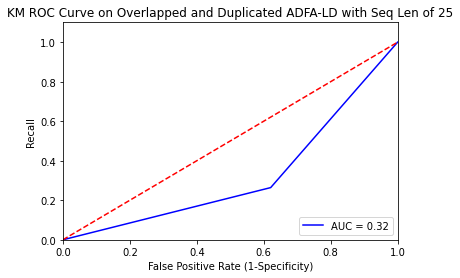

Train AUC: 0.322 vs Test AUC: 0.322



--------------------KM on unclean data --------------------
Confusion Matrix: 
 [[ 8861 14954]
 [32781 11871]]

Testing Accuracy: 0.30
Precision:0.44
Recall: 0.27
False Positive Rate: 0.63

Classification report:
              precision    recall  f1-score   support

           0       0.21      0.37      0.27     23815
           1       0.44      0.27      0.33     44652

    accuracy                           0.30     68467
   macro avg       0.33      0.32      0.30     68467
weighted avg       0.36      0.30      0.31     68467

AUC: 0.32


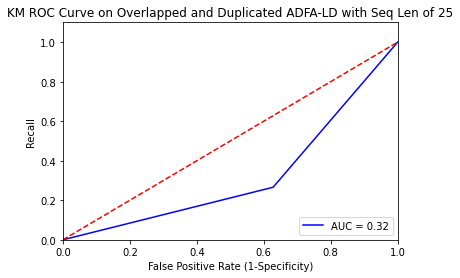

Train AUC: 0.319 vs Test AUC: 0.319


In [ ]:
## TESTING K-MEANS with clean data and unclean data
KM_clean_perf   = test_model(test_clean, y_test_clean, kmeans, 'KM', 'clean'); print('\n\n')
KM_unclean_perf = test_model(test_unclean, y_test_unclean, kmeans, 'KM', 'unclean')

In [ ]:
KM_clean_perf, KM_unclean_perf

({'auc': 0.32167745019501975,
  'fpr': array([0.        , 0.62074541, 1.        ]),
  'tpr': array([0.        , 0.26410031, 1.        ])},
 {'auc': 0.3189661875618648,
  'fpr': array([0.        , 0.62792358, 1.        ]),
  'tpr': array([0.        , 0.26585595, 1.        ])})

# **Logistic Regression**

--------------------LR on clean data --------------------
Confusion Matrix: 
 [[15164  8957]
 [11973 32370]]

Testing Accuracy: 0.69
Precision:0.78
Recall: 0.73
False Positive Rate: 0.37

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59     24121
           1       0.78      0.73      0.76     44343

    accuracy                           0.69     68464
   macro avg       0.67      0.68      0.67     68464
weighted avg       0.70      0.69      0.70     68464

AUC: 0.68


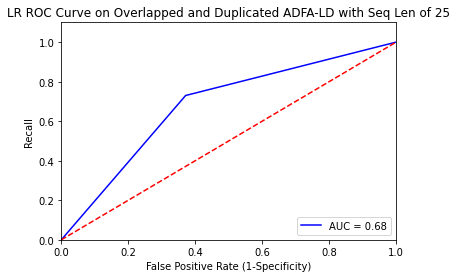

Train AUC: 0.679 vs Test AUC: 0.679



--------------------LR on unclean data --------------------
Confusion Matrix: 
 [[15148  8667]
 [12143 32509]]

Testing Accuracy: 0.70
Precision:0.79
Recall: 0.73
False Positive Rate: 0.36

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.59     23815
           1       0.79      0.73      0.76     44652

    accuracy                           0.70     68467
   macro avg       0.67      0.68      0.68     68467
weighted avg       0.71      0.70      0.70     68467

AUC: 0.68


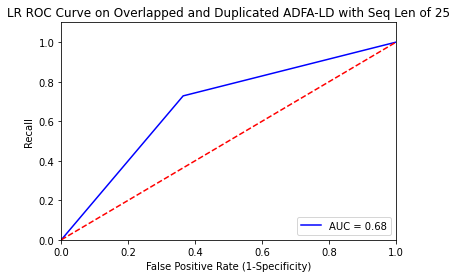

Train AUC: 0.682 vs Test AUC: 0.682


In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set and predict the testing set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression with clean data and unclean data
LR_clean_perf   = test_model(test_clean, y_test_clean, lgModel, 'LR', 'clean'); print('\n\n')
LR_unclean_perf = test_model(test_unclean, y_test_unclean, lgModel, 'LR', 'unclean')

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [ ]:
if len(x_train) > 500000: 
  svm_sz = 0.07  
elif 200000 < len(x_train) < 500000:
  svm_sz = 0.1
elif 100000 < len(x_train) <= 200000:
  svm_sz = 0.4
else:
  svm_sz = 1

svm_sz

0.1

In [ ]:
train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = svm_sz)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1,240,240,78,265,240,240,240,240,78,240,5,221,78,5,6,9,195,10,195,5,140,3,195,3,3
2,309,54,54,54,54,54,54,309,3,54,54,54,54,54,309,3,54,54,54,54,54,309,309,309,3
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
4,192,6,33,5,3,197,192,192,192,6,33,5,3,197,192,192,6,33,5,3,5,6,33,3,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43777,168,265,3,265,168,265,3,265,265,168,265,3,265,3,168,265,3,265,168,265,3,265,265,168,265
43778,168,78,168,168,168,3,3,265,3,168,168,3,168,168,265,168,265,168,265,265,168,168,3,168,168
43779,102,102,102,102,309,27,27,6,102,27,5,102,309,102,85,265,10,102,102,195,27,102,10,6,6
43780,3,168,168,3,168,168,168,168,265,168,265,168,168,3,168,168,265,168,168,168,168,168,265,265,265



****Polynomial kernel model: 
[LibSVM]--------------------SVM on clean data --------------------
Confusion Matrix: 
 [[17257  6864]
 [14850 29493]]

Testing Accuracy: 0.68
Precision:0.81
Recall: 0.67
False Positive Rate: 0.28

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.72      0.61     24121
           1       0.81      0.67      0.73     44343

    accuracy                           0.68     68464
   macro avg       0.67      0.69      0.67     68464
weighted avg       0.71      0.68      0.69     68464

AUC: 0.69


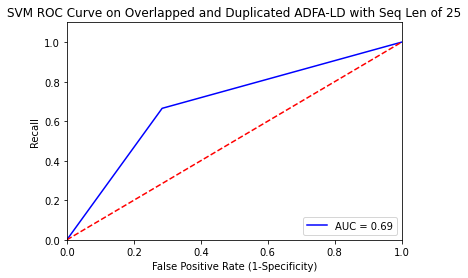

Train AUC: 0.690 vs Test AUC: 0.690



--------------------SVM on unclean data --------------------
Confusion Matrix: 
 [[17001  6814]
 [14991 29661]]

Testing Accuracy: 0.68
Precision:0.81
Recall: 0.66
False Positive Rate: 0.29

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.71      0.61     23815
           1       0.81      0.66      0.73     44652

    accuracy                           0.68     68467
   macro avg       0.67      0.69      0.67     68467
weighted avg       0.72      0.68      0.69     68467

AUC: 0.69


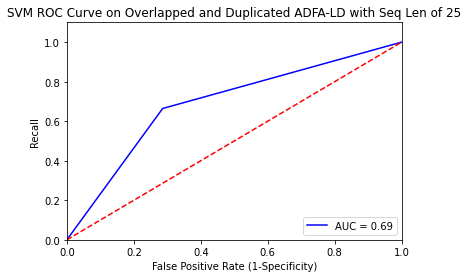

Train AUC: 0.689 vs Test AUC: 0.689


In [ ]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly', verbose = True)

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


## TESTING SVM with clean data and unclean data
SVM_clean_perf   = test_model(test_clean,   y_test_clean,   svm_model, 'SVM', 'clean'); print('\n\n')
SVM_unclean_perf = test_model(test_unclean, y_test_unclean, svm_model, 'SVM', 'unclean')

In [ ]:
# Plot a heatmap confusion matrix
#color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [ ]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in ADFA-LD data is 325
max_syscall = 325
x_train_nn = x_train/max_syscall
x_test_nn = test_clean/max_syscall

In [ ]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),  # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size=128, verbose=1)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/10
3421/3421 [==============================] - 18s 5ms/step - loss: 0.5934 - accuracy: 0.6870
Epoch 2/10
3421/3421 [==============================] - 13s 4ms/step - loss: 0.5748 - accuracy: 0.6917
Epoch 3/10
3421/3421 [==============================] - 9s 2ms/step - loss: 0.5686 - accuracy: 0.6938
Epoch 4/10
3421/3421 [==============================] - 9s 3ms/step - loss: 0.5643 - accuracy: 0.6991
Epoch 5/10
3421/3421 [==============================] - 9s 3ms/step - loss: 0.5606 - accuracy: 0.7035
Epoch 6/10
3421/3421 [==============================] - 8s 2ms/step - loss: 0.5570 - accuracy: 0.7079
Epoch 7/10
3421/3421 [==============================] - 8s 2ms/step - loss: 0.5535 - accuracy: 0.7125
Epoch 8/10
3421/3421 [==============================] - 9s 3ms/step - loss: 0.5503 - accuracy: 0.7170
Epoch 9/10
3421/3421 [==============================] - 8s 2ms/step - loss: 0.5473 - accuracy: 0.7207
Epoch 10/10
3421/3421 [==============================] - 8s 2ms/step - loss: 0.5

In [ ]:
# Get predict Training classes
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)

--------------------NN on clean data --------------------
Confusion Matrix: 
 [[  456 23665]
 [  314 44029]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 0.99
False Positive Rate: 0.98

Classification report:
              precision    recall  f1-score   support

           0       0.59      0.02      0.04     24121
           1       0.65      0.99      0.79     44343

    accuracy                           0.65     68464
   macro avg       0.62      0.51      0.41     68464
weighted avg       0.63      0.65      0.52     68464

AUC: 0.51


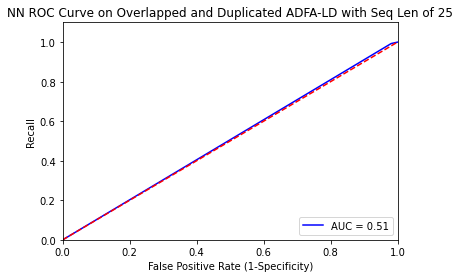

Train AUC: 0.506 vs Test AUC: 0.506



--------------------NN on unclean data --------------------
Confusion Matrix: 
 [[  447 23368]
 [  299 44353]]

Testing Accuracy: 0.65
Precision:0.65
Recall: 0.99
False Positive Rate: 0.98

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.02      0.04     23815
           1       0.65      0.99      0.79     44652

    accuracy                           0.65     68467
   macro avg       0.63      0.51      0.41     68467
weighted avg       0.64      0.65      0.53     68467

AUC: 0.51


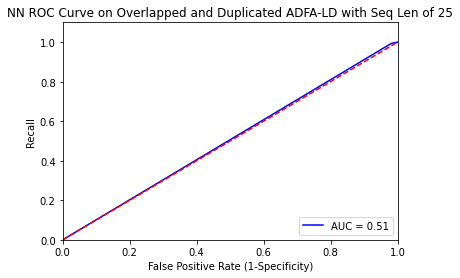

Train AUC: 0.506 vs Test AUC: 0.506


In [ ]:
## TESTING NN with clean data and unclean data
NN_clean_perf   = test_model(test_clean,   y_test_clean,   nn_model, 'NN', 'clean'); print('\n\n')
NN_unclean_perf = test_model(test_unclean, y_test_unclean, nn_model, 'NN', 'unclean')

In [ ]:
nn_model.summary()

#history.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

--------------------DT on clean data --------------------
Confusion Matrix: 
 [[19705  4416]
 [ 5197 39146]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.88
False Positive Rate: 0.18

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     24121
           1       0.90      0.88      0.89     44343

    accuracy                           0.86     68464
   macro avg       0.84      0.85      0.85     68464
weighted avg       0.86      0.86      0.86     68464

AUC: 0.85


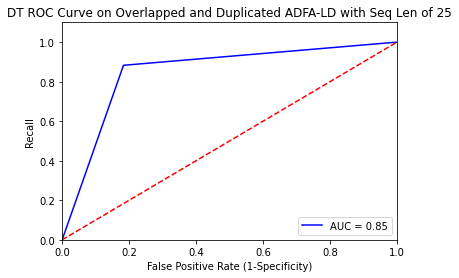

Train AUC: 0.850 vs Test AUC: 0.850



--------------------DT on unclean data --------------------
Confusion Matrix: 
 [[19388  4427]
 [ 5093 39559]]

Testing Accuracy: 0.86
Precision:0.90
Recall: 0.89
False Positive Rate: 0.19

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     23815
           1       0.90      0.89      0.89     44652

    accuracy                           0.86     68467
   macro avg       0.85      0.85      0.85     68467
weighted avg       0.86      0.86      0.86     68467

AUC: 0.85


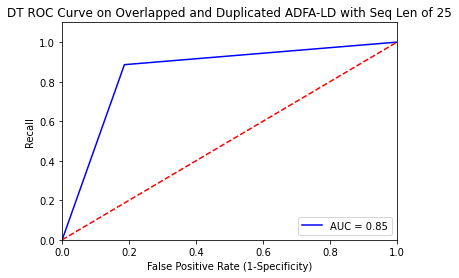

Train AUC: 0.850 vs Test AUC: 0.850


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING DT with clean data and unclean data
DT_clean_perf   = test_model(test_clean,   y_test_clean,   decTree, 'DT', 'clean'); print('\n\n')
DT_unclean_perf = test_model(test_unclean, y_test_unclean, decTree, 'DT', 'unclean')

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.




--------------------RF on clean data --------------------
Confusion Matrix: 
 [[21796  2325]
 [ 2981 41362]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.93
False Positive Rate: 0.10

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     24121
           1       0.95      0.93      0.94     44343

    accuracy                           0.92     68464
   macro avg       0.91      0.92      0.92     68464
weighted avg       0.92      0.92      0.92     68464

AUC: 0.92


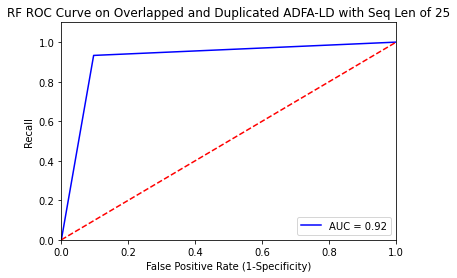

Train AUC: 0.918 vs Test AUC: 0.918



--------------------RF on unclean data --------------------
Confusion Matrix: 
 [[21396  2419]
 [ 3005 41647]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.93
False Positive Rate: 0.10

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     23815
           1       0.95      0.93      0.94     44652

    accuracy                           0.92     68467
   macro avg       0.91      0.92      0.91     68467
weighted avg       0.92      0.92      0.92     68467

AUC: 0.92


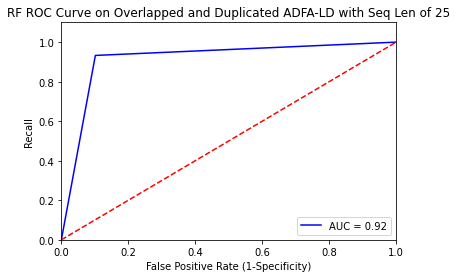

Train AUC: 0.916 vs Test AUC: 0.916


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING RF with clean data and unclean data
RF_clean_perf   = test_model(test_clean,   y_test_clean,   randomForest, 'RF', 'clean'); print('\n\n')
RF_unclean_perf = test_model(test_unclean, y_test_unclean, randomForest, 'RF', 'unclean')

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

--------------------KNN on clean data --------------------
Confusion Matrix: 
 [[18720  5401]
 [13585 30758]]

Testing Accuracy: 0.72
Precision:0.85
Recall: 0.69
False Positive Rate: 0.22

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.66     24121
           1       0.85      0.69      0.76     44343

    accuracy                           0.72     68464
   macro avg       0.72      0.73      0.71     68464
weighted avg       0.76      0.72      0.73     68464

AUC: 0.73


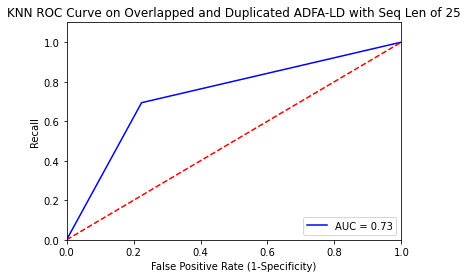

Train AUC: 0.735 vs Test AUC: 0.735



--------------------KNN on unclean data --------------------
Confusion Matrix: 
 [[18529  5286]
 [13561 31091]]

Testing Accuracy: 0.72
Precision:0.85
Recall: 0.70
False Positive Rate: 0.22

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.66     23815
           1       0.85      0.70      0.77     44652

    accuracy                           0.72     68467
   macro avg       0.72      0.74      0.72     68467
weighted avg       0.76      0.72      0.73     68467

AUC: 0.74


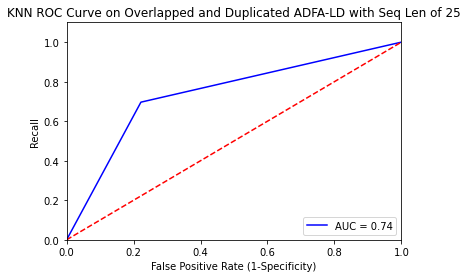

Train AUC: 0.737 vs Test AUC: 0.737


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=9, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING KNN with clean data and unclean data
KNN_clean_perf   = test_model(test_clean,   y_test_clean,   KNN, 'KNN', 'clean'); print('\n\n')
KNN_unclean_perf = test_model(test_unclean, y_test_unclean, KNN, 'KNN', 'unclean')

# **Naive Bayes**

--------------------NB on clean data --------------------
Confusion Matrix: 
 [[15418  8703]
 [12157 32186]]

Testing Accuracy: 0.70
Precision:0.79
Recall: 0.73
False Positive Rate: 0.36

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60     24121
           1       0.79      0.73      0.76     44343

    accuracy                           0.70     68464
   macro avg       0.67      0.68      0.68     68464
weighted avg       0.71      0.70      0.70     68464

AUC: 0.68


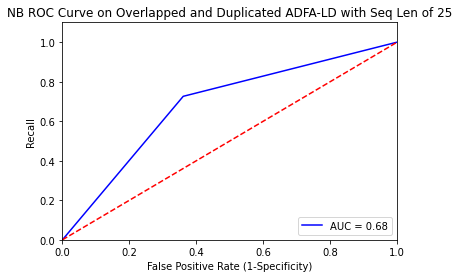

Train AUC: 0.683 vs Test AUC: 0.683



--------------------NB on unclean data --------------------
Confusion Matrix: 
 [[15389  8426]
 [12288 32364]]

Testing Accuracy: 0.70
Precision:0.79
Recall: 0.72
False Positive Rate: 0.35

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60     23815
           1       0.79      0.72      0.76     44652

    accuracy                           0.70     68467
   macro avg       0.67      0.69      0.68     68467
weighted avg       0.71      0.70      0.70     68467

AUC: 0.69


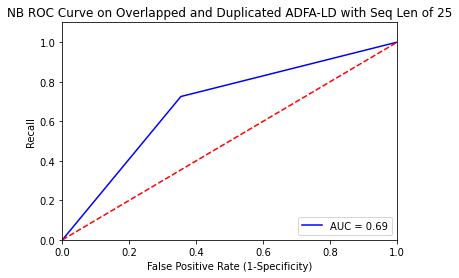

Train AUC: 0.685 vs Test AUC: 0.685


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING KNN with clean data and unclean data
NB_clean_perf   = test_model(test_clean,   y_test_clean,   NaiveBayes, 'NB', 'clean'); print('\n\n')
NB_unclean_perf = test_model(test_unclean, y_test_unclean, NaiveBayes, 'NB', 'unclean')

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
#graph_multi_ROC()

In [ ]:
print('KM_clean_perf =', KM_clean_perf);   print('KM_unclean_perf =', KM_unclean_perf)
print('LR_clean_perf =', LR_clean_perf);   print('LR_unclean_perf =', LR_unclean_perf)
print('SVM_clean_perf =',SVM_clean_perf);  print('SVM_unclean_perf =', SVM_unclean_perf)
print('NN_clean_perf =', NN_clean_perf);   print('NN_unclean_perf =', NN_unclean_perf)
print('DT_clean_perf =', DT_clean_perf);   print('DT_unclean_perf =', DT_unclean_perf)
print('RF_clean_perf =', RF_clean_perf);   print('RF_unclean_perf =', RF_unclean_perf)
print('KNN_clean_perf =',KNN_clean_perf);  print('KNN_unclean_perf =', KNN_unclean_perf)
print('NB_clean_perf =', NB_clean_perf);   print('NB_unclean_perf =', NB_unclean_perf)


KM_clean_perf = {'fpr': array([0.        , 0.62074541, 1.        ]), 'tpr': array([0.        , 0.26410031, 1.        ]), 'auc': 0.32167745019501975}
KM_unclean_perf = {'fpr': array([0.        , 0.62792358, 1.        ]), 'tpr': array([0.        , 0.26585595, 1.        ]), 'auc': 0.3189661875618648}
LR_clean_perf = {'fpr': array([0.        , 0.37133618, 1.        ]), 'tpr': array([0.       , 0.7299912, 1.       ]), 'auc': 0.6793275124166029}
LR_unclean_perf = {'fpr': array([0.       , 0.3639303, 1.       ]), 'tpr': array([0.        , 0.72805249, 1.        ]), 'auc': 0.6820610994085712}
SVM_clean_perf = {'fpr': array([0.        , 0.28456532, 1.        ]), 'tpr': array([0.        , 0.66511061, 1.        ]), 'auc': 0.6902726492247616}
SVM_unclean_perf = {'fpr': array([0.        , 0.28612219, 1.        ]), 'tpr': array([0.        , 0.66427036, 1.        ]), 'auc': 0.6890740827674671}
NN_clean_perf = {'fpr': array([0.        , 0.98109531, 1.        ]), 'tpr': array([0.        , 0.99291884, 1.

# **Note**

**Cleaned Data**
After changing the sequence length to 15 and only removing duplicate data in intrusion has significantly increased all model performances. BERT and GPT outperform the rest with over 0.97 AUC scores.

# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name, clean):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + "-model.txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test_{} = ".format(model_name, clean) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(KM_clean_perf, 'KM', "clean"); write_to_file(KM_unclean_perf, 'KM', "unclean")
write_to_file(LR_clean_perf, 'LR', "clean"); write_to_file(LR_unclean_perf, 'LR', "unclean")
write_to_file(SVM_clean_perf, 'SVM', "clean"); write_to_file(SVM_unclean_perf, 'SVM', "unclean")
write_to_file(NN_clean_perf, 'NN', "clean"); write_to_file(NN_unclean_perf, 'NN', "unclean")
write_to_file(DT_clean_perf, 'DT', "clean"); write_to_file(DT_unclean_perf, 'DT', "unclean")
write_to_file(RF_clean_perf, 'RF', "clean"); write_to_file(RF_unclean_perf, 'RF', "unclean")
write_to_file(KNN_clean_perf, 'KNN', "clean"); write_to_file(KNN_unclean_perf, 'KNN', "unclean")
write_to_file(NB_clean_perf, 'NB', "clean"); write_to_file(NB_unclean_perf, 'NB', "unclean")




print('KM_test =', KM_test)
print('LR_test =', LR_test)
print('SVM_test =', SVM_test)
print('NN_test =', NN_test)
print('DT_test =', DT_test)
print('RF_test =', RF_test)
print('KNN_test =', KNN_test)
print('NB_test =', NB_test)
print('BERT_test =', BERT_test)
print('GPT_test =', GPT_test)
